In [1]:
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')


In [2]:
import os
print("LD_LIBRARY_PATH:", os.environ.get('LD_LIBRARY_PATH'))


LD_LIBRARY_PATH: /usr/local/cuda/lib64:


In [3]:
import tensorflow as tf
print("GPUs detected:", tf.config.list_physical_devices('GPU'))


GPUs detected: []


In [4]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models #type: ignore
from tensorflow.keras.applications import ResNet50  #type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator #type: ignore
from tensorflow.keras.utils import to_categorical #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow.keras.optimizers.schedules import ExponentialDecay #type: ignore
from tensorflow.keras.regularizers import l2 #type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau #type: ignore
from tensorflow.keras.metrics import AUC, Precision, Recall #type: ignore

In [5]:
class ImageDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.images = []
        self.labels = []
        self.class_names = ['no_plaga', 'plaga'] 
        
    def load_data(self):
        """Carga datos con validación mejorada"""
        total_images = 0
        class_counts = {}
        
        for idx, label in enumerate(self.class_names):
            label_dir = os.path.join(self.data_dir, label)
            if not os.path.exists(label_dir):
                print(f"Advertencia: no existe la carpeta {label_dir}")
                continue
                
            class_count = 0
            for image_name in os.listdir(label_dir):
                if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    continue
                    
                img_path = os.path.join(label_dir, image_name)
                img_array = self.load_and_preprocess_image(img_path)
                if img_array is not None:
                    self.images.append(img_array)
                    self.labels.append(idx)
                    class_count += 1
                    total_images += 1
            
            class_counts[label] = class_count
            print(f"Clase '{label}': {class_count} imágenes")
        
        print(f"Total de imágenes cargadas: {total_images}")

        if class_counts:
            max_count = max(class_counts.values())
            min_count = min(class_counts.values())
            ratio = max_count / min_count if min_count > 0 else float('inf')
            
            if ratio > 3:
                print(f"Desbalance detectado: ratio {ratio:.2f}:1")
                print("Considera usar class_weight o data augmentation")
        
        return class_counts

    def load_and_preprocess_image(self, img_path):
        """Carga y preprocesa imagen con manejo de errores mejorado"""
        try:
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            return img_array
        except Exception as e:
            print(f"Error al cargar {img_path}: {e}")
            return None

In [6]:
print("Clasificador de Plagas o No Plagas")
print("=" * 50)

data_dir = 'data_2/'
dataset = ImageDataset(data_dir)
class_counts = dataset.load_data()

if not dataset.images:
    print("No se cargaron imágenes.")
    exit(1)

Clasificador de Plagas o No Plagas
Clase 'no_plaga': 2417 imágenes
Clase 'plaga': 2217 imágenes
Total de imágenes cargadas: 4634


In [7]:
images = np.array(dataset.images)
labels = np.array(dataset.labels)
labels_bin = labels.astype('float32')

print(f"\nDatos preparados:")
print(f"Imágenes: {images.shape}")
print(f"Etiquetas: {labels_bin.shape}")


Datos preparados:
Imágenes: (4634, 224, 224, 3)
Etiquetas: (4634,)


In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    images, labels_bin,
    test_size=0.2,
    random_state=42,
    stratify=labels
)
print(f"\nDivisión de datos:")   
print(f"Entrenamiento: {X_train.shape[0]} imágenes")
print(f"Validación: {X_val.shape[0]} imágenes")


División de datos:
Entrenamiento: 3707 imágenes
Validación: 927 imágenes


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization,
    Multiply, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau,
    ModelCheckpoint, TensorBoard
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import (
    Precision, Recall, AUC, F1Score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model

In [ ]:
def modelo_base(input_shape=(224, 224, 3)):
    

    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet')

    base_model.trainable = True

    print(f"Número de capas en el modelo base: {len(base_model.layers)}")

    fine_tune_at = 120 

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    print(f"Capas de la 1 a la {fine_tune_at} congeladas.")
    print(f"Capas de la {fine_tune_at} en adelante listas para fine-tuning.")

    inputs = base_model.input

    x = base_model.output 
    x = layers.GlobalAveragePooling2D()(x) 
    x = layers.Dropout(0.3)(x) 
    outputs = layers.Dense(1, activation='sigmoid')(x) 
    modelo_tl = Model(inputs=inputs, outputs=outputs)

    
    # Compilación del modelo
    modelo_tl.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(), Recall(), AUC()]
    )
    return modelo_tl

modelo = modelo_base()

I0000 00:00:1749619120.978871   29322 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Número de capas en el modelo base: 154
Capas de la 1 a la 120 congeladas.
Capas de la 120 en adelante listas para fine-tuning.


In [ ]:
def configurar_callbacks():
    """
    Configura los callbacks para el entrenamiento.
    """
    callbacks = [
        EarlyStopping(
            patience=3,
            min_delta=0.001,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        ModelCheckpoint(
            filepath='mejor_modelo.h5',
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        )
    ]
    
    return callbacks

callbacks = configurar_callbacks()

In [ ]:
def entrenar_modelo(modelo, X_train, y_train, X_val, y_val, callbacks, epochs, batch_size):
    """
    Entrena el modelo con los generadores y callbacks configurados.
    """
    history = modelo.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        callbacks=callbacks,
        batch_size=batch_size,
        verbose=1
    )
    
    return history


In [14]:
history = entrenar_modelo(modelo, X_train, y_train, X_val, y_val, callbacks, epochs=15, batch_size=16)

Epoch 1/15


I0000 00:00:1749619131.429833   29668 service.cc:152] XLA service 0x7fb3e0001f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749619131.429920   29668 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-06-11 00:18:51.569560: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749619132.423045   29668 cuda_dnn.cc:529] Loaded cuDNN version 91001
2025-06-11 00:19:00.666984: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv %cudnn-conv.104 = (f32[16,576,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,576,14,14]{3,2,1,0} %bitcast.16318, f32[576,1,3,3]{3,2,1,0} %bitcast.16325), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=576, custom_call_target="__cudnn$convForward", metadata={op_typ

230/232 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6897 - auc: 0.7709 - loss: 0.5490 - precision: 0.6763 - recall: 0.6888

2025-06-11 00:19:19.716224: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-11 00:19:19.919011: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6908 - auc: 0.7721 - loss: 0.5476 - precision: 0.6774 - recall: 0.6898

2025-06-11 00:19:39.303999: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-11 00:19:39.707666: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-11 00:19:39.908377: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-11 00:19:40.053546: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv %cudnn-conv.100 = (f32[15,960,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,960,7,7]{3,2,1,0} %bitcast.6665, f32[960,1,3,3]{3,2,1,0} %bitcast.6672), window={size=3x3 pad=

232/232 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - accuracy: 0.6914 - auc: 0.7727 - loss: 0.5470 - precision: 0.6780 - recall: 0.6903 - val_accuracy: 0.8576 - val_auc: 0.9853 - val_loss: 0.3367 - val_precision: 1.0000 - val_recall: 0.7020 - learning_rate: 1.0000e-05
Epoch 2/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9424 - auc: 0.9886 - loss: 0.1755 - precision: 0.9505 - recall: 0.9267 - val_accuracy: 0.8306 - val_auc: 0.9925 - val_loss: 0.3766 - val_precision: 1.0000 - val_recall: 0.6456 - learning_rate: 1.0000e-05
Epoch 3/15
229/232 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9675 - auc: 0.9951 - loss: 0.1083 - precision: 0.9691 - recall: 0.9628

232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9675 - auc: 0.9951 - loss: 0.1083 - precision: 0.9690 - recall: 0.9628 - val_accuracy: 0.9094 - val_auc: 0.9951 - val_loss: 0.2250 - val_precision: 1.0000 - val_recall: 0.8104 - learning_rate: 1.0000e-05
Epoch 4/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9705 - auc: 0.9955 - loss: 0.0937 - precision: 0.9813 - recall: 0.9569

232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9705 - auc: 0.9955 - loss: 0.0936 - precision: 0.9813 - recall: 0.9569 - val_accuracy: 0.9342 - val_auc: 0.9961 - val_loss: 0.1636 - val_precision: 1.0000 - val_recall: 0.8623 - learning_rate: 1.0000e-05
Epoch 5/15
229/232 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9740 - auc: 0.9966 - loss: 0.0762 - precision: 0.9816 - recall: 0.9634

232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9740 - auc: 0.9966 - loss: 0.0761 - precision: 0.9815 - recall: 0.9635 - val_accuracy: 0.9407 - val_auc: 0.9965 - val_loss: 0.1499 - val_precision: 1.0000 - val_recall: 0.8758 - learning_rate: 1.0000e-05
Epoch 6/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9837 - auc: 0.9982 - loss: 0.0561 - precision: 0.9910 - recall: 0.9743

232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9837 - auc: 0.9982 - loss: 0.0561 - precision: 0.9909 - recall: 0.9743 - val_accuracy: 0.9525 - val_auc: 0.9967 - val_loss: 0.1272 - val_precision: 1.0000 - val_recall: 0.9007 - learning_rate: 1.0000e-05
Epoch 7/15
231/232 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9827 - auc: 0.9978 - loss: 0.0586 - precision: 0.9873 - recall: 0.9773

232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9827 - auc: 0.9978 - loss: 0.0586 - precision: 0.9873 - recall: 0.9773 - val_accuracy: 0.9644 - val_auc: 0.9980 - val_loss: 0.0922 - val_precision: 1.0000 - val_recall: 0.9255 - learning_rate: 1.0000e-05
Epoch 8/15
229/232 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9879 - auc: 0.9994 - loss: 0.0409 - precision: 0.9894 - recall: 0.9852

232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9879 - auc: 0.9994 - loss: 0.0409 - precision: 0.9893 - recall: 0.9852 - val_accuracy: 0.9795 - val_auc: 0.9994 - val_loss: 0.0582 - val_precision: 1.0000 - val_recall: 0.9571 - learning_rate: 1.0000e-05
Epoch 9/15
229/232 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9903 - auc: 0.9995 - loss: 0.0369 - precision: 0.9922 - recall: 0.9874

232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9903 - auc: 0.9995 - loss: 0.0368 - precision: 0.9923 - recall: 0.9874 - val_accuracy: 0.9817 - val_auc: 0.9995 - val_loss: 0.0539 - val_precision: 1.0000 - val_recall: 0.9616 - learning_rate: 1.0000e-05
Epoch 10/15
231/232 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9948 - auc: 0.9998 - loss: 0.0289 - precision: 0.9920 - recall: 0.9959

232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9948 - auc: 0.9998 - loss: 0.0289 - precision: 0.9920 - recall: 0.9958 - val_accuracy: 0.9860 - val_auc: 0.9996 - val_loss: 0.0432 - val_precision: 0.9977 - val_recall: 0.9729 - learning_rate: 1.0000e-05
Epoch 11/15
230/232 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9939 - auc: 0.9997 - loss: 0.0262 - precision: 0.9971 - recall: 0.9901

232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9939 - auc: 0.9997 - loss: 0.0262 - precision: 0.9971 - recall: 0.9901 - val_accuracy: 0.9849 - val_auc: 0.9997 - val_loss: 0.0410 - val_precision: 0.9977 - val_recall: 0.9707 - learning_rate: 1.0000e-05
Epoch 12/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9927 - auc: 0.9997 - loss: 0.0239 - precision: 0.9961 - recall: 0.9887 - val_accuracy: 0.9849 - val_auc: 0.9996 - val_loss: 0.0421 - val_precision: 0.9977 - val_recall: 0.9707 - learning_rate: 1.0000e-05
Epoch 13/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9948 - auc: 0.9999 - loss: 0.0160 - precision: 0.9957 - recall: 0.9936

232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9948 - auc: 0.9999 - loss: 0.0160 - precision: 0.9956 - recall: 0.9936 - val_accuracy: 0.9860 - val_auc: 0.9997 - val_loss: 0.0322 - val_precision: 0.9954 - val_recall: 0.9752 - learning_rate: 1.0000e-05
Epoch 14/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9956 - auc: 0.9999 - loss: 0.0170 - precision: 0.9991 - recall: 0.9919 - val_accuracy: 0.9871 - val_auc: 0.9997 - val_loss: 0.0345 - val_precision: 0.9977 - val_recall: 0.9752 - learning_rate: 1.0000e-05
Epoch 15/15
229/232 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9961 - auc: 0.9999 - loss: 0.0136 - precision: 0.9961 - recall: 0.9957

232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9961 - auc: 0.9999 - loss: 0.0136 - precision: 0.9961 - recall: 0.9957 - val_accuracy: 0.9871 - val_auc: 0.9998 - val_loss: 0.0288 - val_precision: 0.9977 - val_recall: 0.9752 - learning_rate: 1.0000e-05


In [ ]:
def evaluar_modelo_binario(modelo, X_val, y_val):
    """
    Evalúa el modelo binario con métricas relevantes.
    """
    y_pred_proba = modelo.predict(X_val)
    y_pred_class = (y_pred_proba >= 0.5).astype('int32')
    
    metrics = {
        'accuracy': accuracy_score(y_val, y_pred_class),
        'precision': precision_score(y_val, y_pred_class),
        'recall': recall_score(y_val, y_pred_class),
        'f1': f1_score(y_val, y_pred_class),
        'auc': roc_auc_score(y_val, y_pred_proba),
        'specificity': recall_score(y_val, y_pred_class, pos_label=0),
        'sensitivity': recall_score(y_val, y_pred_class, pos_label=1)
    }
    
    conf_matrix = confusion_matrix(y_val, y_pred_class)
    
    return metrics, conf_matrix

metrics, conf_matrix = evaluar_modelo_binario(modelo, X_val, y_val)
print("\nMétricas del modelo:")
for metrica, valor in metrics.items():
    print(f"{metrica}: {valor:.4f}")

print("\nMatriz de confusión:")
print(conf_matrix)

2025-06-11 00:20:54.138730: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-11 00:20:54.337765: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-11 00:20:54.536361: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

2025-06-11 00:21:07.322922: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-11 00:21:07.659689: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-11 00:21:07.858034: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-11 00:21:07.913652: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv %cudnn-conv.100 = (f32[31,960,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,960,7,7]{3,2,1,0} %bitcast.5942, f32[960,1,3,3]{3,2,1,0} %bitcast.5949), window={size=3x3 pad=

29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 541ms/step

Métricas del modelo:
accuracy: 0.9871
precision: 0.9977
recall: 0.9752
f1: 0.9863
auc: 0.9998
specificity: 0.9979
sensitivity: 0.9752

Matriz de confusión:
[[483   1]
 [ 11 432]]


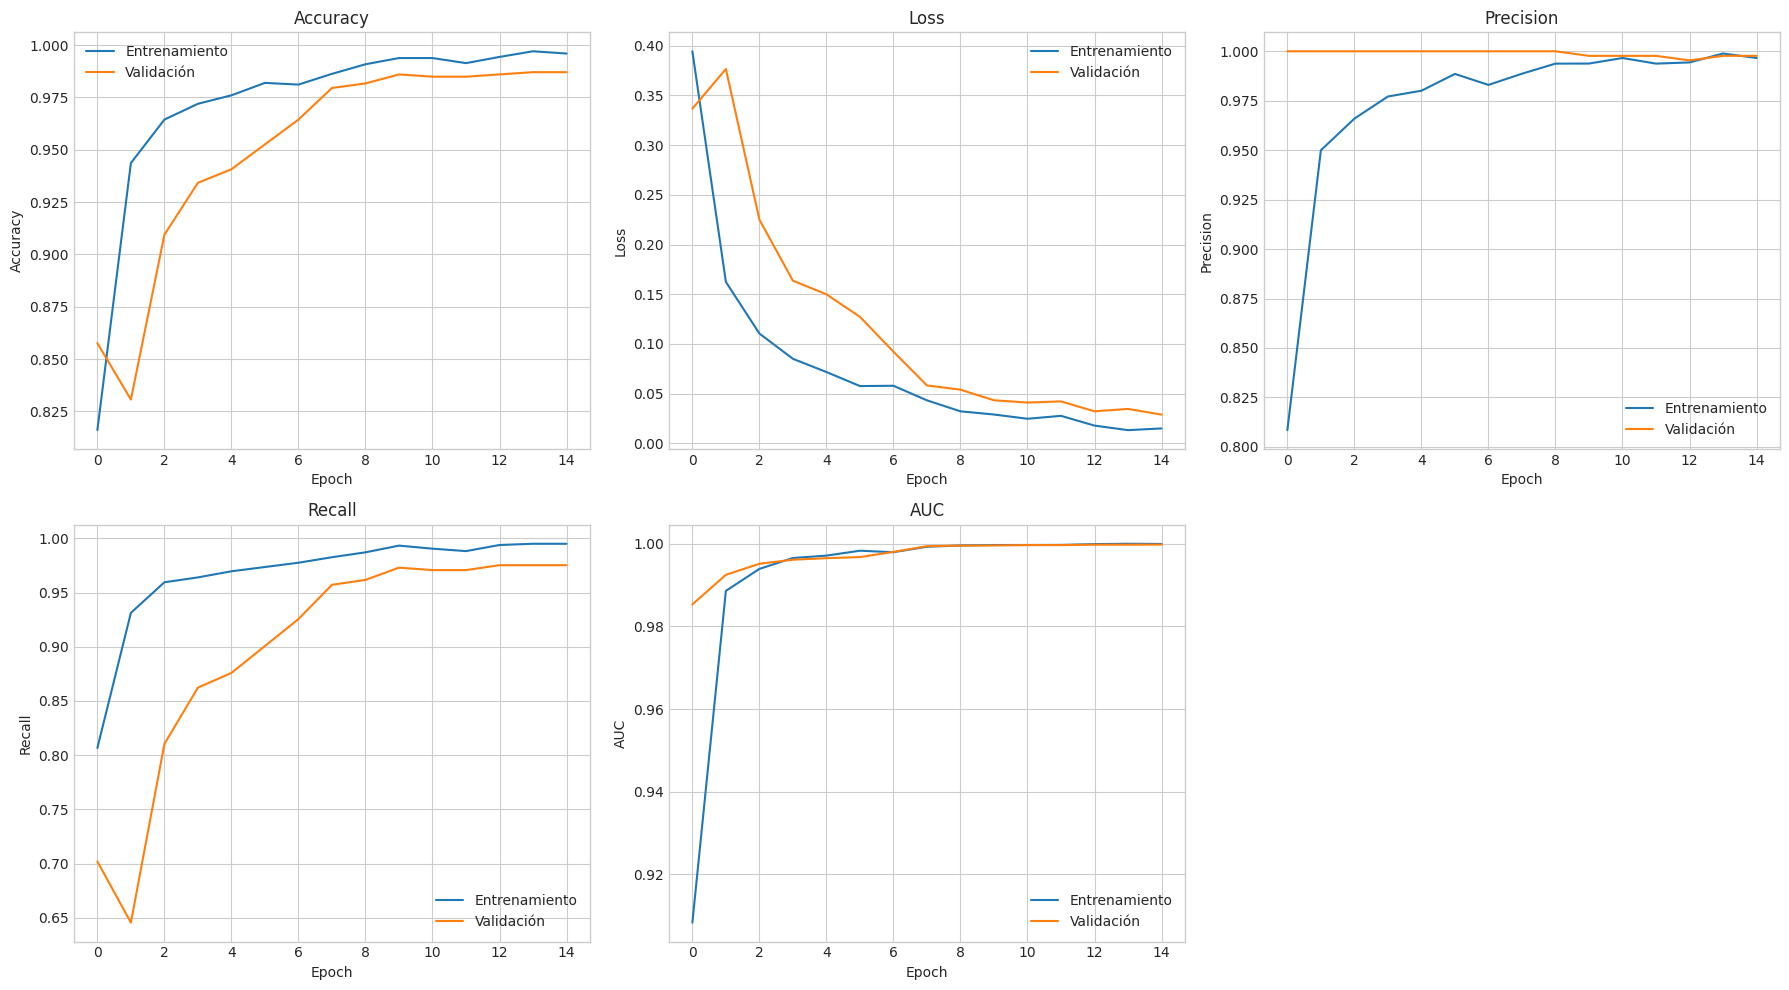

In [ ]:

def visualizar_resultados(history):
    """
    Visualiza las métricas de entrenamiento.
    """
    acc_key = [k for k in history.history.keys() if 'accuracy' in k and 'val' not in k][0]
    val_acc_key = [k for k in history.history.keys() if 'accuracy' in k and 'val' in k][0]
    loss_key = [k for k in history.history.keys() if 'loss' in k and 'val' not in k][0]
    val_loss_key = [k for k in history.history.keys() if 'loss' in k and 'val' in k][0]
    precision_key = [k for k in history.history.keys() if 'precision' in k and 'val' not in k][0]
    val_precision_key = [k for k in history.history.keys() if 'precision' in k and 'val' in k][0]
    recall_key = [k for k in history.history.keys() if 'recall' in k and 'val' not in k][0]
    val_recall_key = [k for k in history.history.keys() if 'recall' in k and 'val' in k][0]
    auc_key = [k for k in history.history.keys() if 'auc' in k and 'val' not in k][0]
    val_auc_key = [k for k in history.history.keys() if 'auc' in k and 'val' in k][0]

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(18, 10))

    plt.subplot(2, 3, 1)
    plt.plot(history.history[acc_key], label='Entrenamiento')
    plt.plot(history.history[val_acc_key], label='Validación')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(history.history[loss_key], label='Entrenamiento')
    plt.plot(history.history[val_loss_key], label='Validación')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(history.history[precision_key], label='Entrenamiento')
    plt.plot(history.history[val_precision_key], label='Validación')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(history.history[recall_key], label='Entrenamiento')
    plt.plot(history.history[val_recall_key], label='Validación')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(history.history[auc_key], label='Entrenamiento')
    plt.plot(history.history[val_auc_key], label='Validación')
    plt.title('AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

visualizar_resultados(history)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


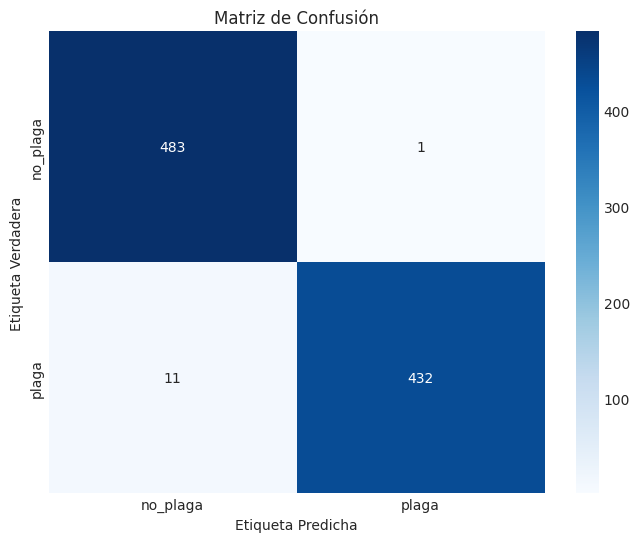

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = modelo.predict(X_val)
y_pred = (y_pred_probs >= 0.5).astype('int32')
y_true = y_val

cm = confusion_matrix(y_true, y_pred)

class_names = ['no_plaga', 'plaga']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()


2025-06-11 00:21:20.964364: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-11 00:21:21.301231: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-11 00:21:21.487540: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/tmp/ipykernel_29322/277037566.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = int(pred_probs >= 0.5)  # Convertir a entero


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


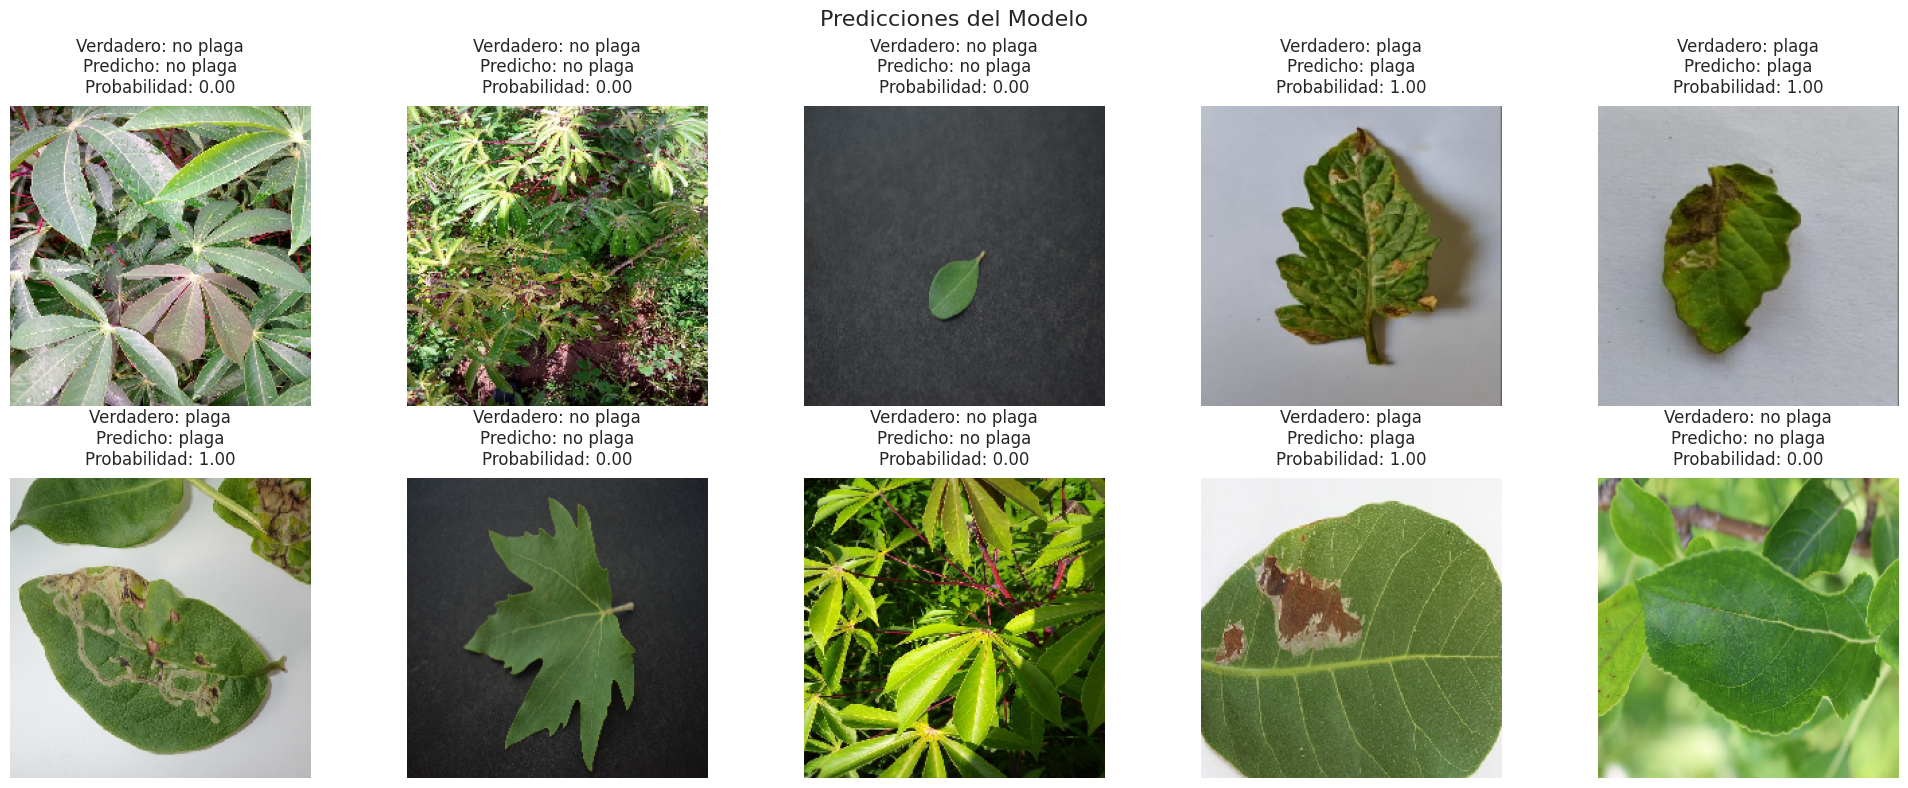

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def visualizar_predicciones_binarias(X_val, y_val, modelo, class_names=['no plaga', 'plaga']):
    """
    Visualiza predicciones aleatorias del conjunto de validación.
    """
    indices = random.sample(range(len(X_val)), 10)

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle('Predicciones del Modelo', fontsize=16)

    for i, idx in enumerate(indices):
        img = X_val[idx]
        true_label = int(y_val[idx])
        pred_probs = modelo.predict(np.expand_dims(img, axis=0))
        pred_label = int(pred_probs >= 0.5)

        prob_pos = pred_probs[0][1] if pred_probs.shape[1] > 1 else pred_probs[0][0]

        ax = axes[i // 5, i % 5]

        ax.imshow(img)
        ax.axis('off')

        title = (
            f"Verdadero: {class_names[true_label]}\n"
            f"Predicho: {class_names[pred_label]}\n"
            f"Probabilidad: {prob_pos:.2f}"
        )
        ax.set_title(title, pad=10)
    
    plt.tight_layout()
    plt.show()

visualizar_predicciones_binarias(X_val, y_val, modelo)

🔬 Analizando errores del modelo en el set de validación...
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
📉 Se encontraron 12 errores de clasificación.


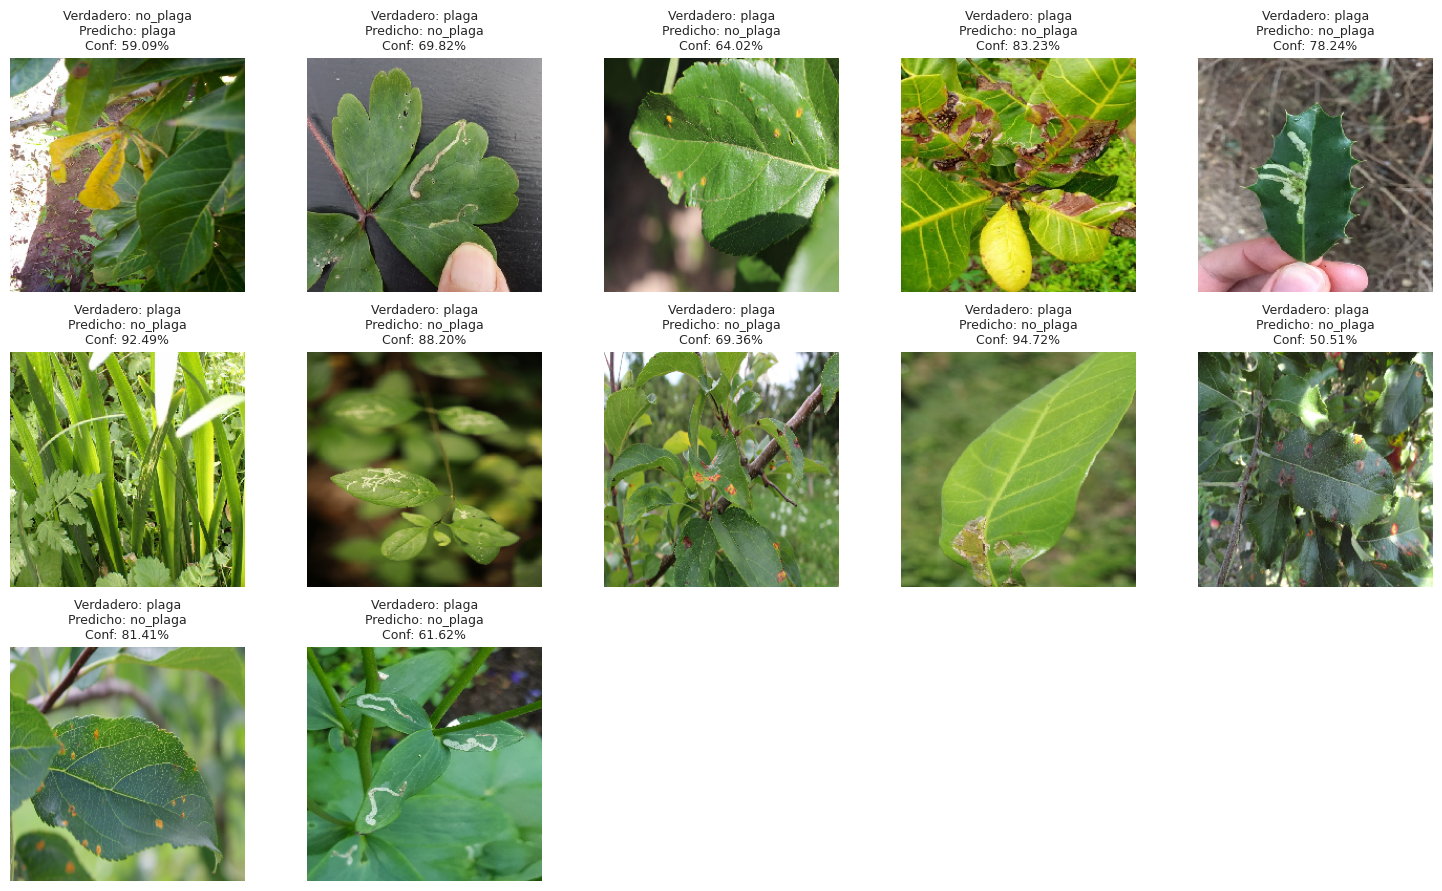

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualizar_errores(modelo, X_val, y_val, class_names):
    """
    Identifica y visualiza las imágenes que el modelo clasificó incorrectamente.
    Versión final robusta para clasificación binaria.
    """
    print("Analizando errores del modelo en el set de validación...")
    

    y_pred_probs = modelo.predict(X_val)
    y_pred_class = (y_pred_probs > 0.5).astype("int").flatten()
    y_true_class = y_val.astype("int")
    error_indices = np.where(y_pred_class != y_true_class)[0]
    
    if len(error_indices) == 0:
        print("No hay errores")
        return
        
    print(f"Se encontraron {len(error_indices)} errores de clasificación.")

    error_images = X_val[error_indices]
    error_true_labels = y_true_class[error_indices]
    error_pred_labels = y_pred_class[error_indices]
    probs_of_errors = y_pred_probs[error_indices].flatten()
    error_pred_probs = [p if pred == 1 else 1-p for p, pred in zip(probs_of_errors, error_pred_labels)]
    n_cols = 5
    n_rows = (len(error_indices) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 3 * n_rows))
    for i in range(len(error_indices)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(error_images[i])
        
        true_label_name = class_names[error_true_labels[i]]
        pred_label_name = class_names[error_pred_labels[i]]
        pred_prob = error_pred_probs[i]
        
        plt.title(f"Verdadero: {true_label_name}\nPredicho: {pred_label_name}\nConf: {pred_prob:.2%}", fontsize=9)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

class_names_plagas = ['no_plaga', 'plaga']
visualizar_errores(modelo, X_val, y_val, class_names_plagas)

In [19]:
modelo.save("modelo_plagas_binariov2_prueba.keras")

In [21]:
modelo.save("modelo_plagas_binariov2.h5")